In [1511]:
import networkx as nx
from matplotlib import pyplot as plt
import random
from IPython.display import clear_output
import time
import math

In [1512]:
plt_options = {
  "node_size": 350,
  "node_color": "white",
  "edgecolors": "black",
  "with_labels": True,
  "font_size": 8
}

agent_path_draw_delay = 1

In [1513]:
def setup_road(n_edges_to_remove, m = 5, n = 5):
  G = nx.grid_2d_graph(m, n)

  available_edges = list(G.edges)

  max_edges_to_remove = len(list(G.edges)) - len(list(G.nodes)) + 1

  i = 0

  while i < n_edges_to_remove and i < max_edges_to_remove:
    selected_edge = random.choice(available_edges)
    G.remove_edge(*selected_edge)

    if not nx.is_connected(G):
      G.add_edge(*selected_edge)
    else:
      i += 1

    available_edges.remove(selected_edge)

  return G

In [1514]:
def draw_agent_path(path, road, current_crossroads, visited_crossroads):
    edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    edge_labels = {edge: i + 1 for i, edge in enumerate(edges)}

    pos = {(x,y):(y,-x) for x,y in road.nodes()}

    path_node_color = ['red' if node == current_crossroads else 'yellowgreen' for node in path]
    visited_crossroads_node_color = ['gray' if node in visited_crossroads else 'white' for node in road.nodes]

    plt.figure(figsize=(5,5))
    nx.draw(road, pos=pos, **{ **plt_options, 'node_color': visited_crossroads_node_color })
    nx.draw_networkx_nodes(road, nodelist=path, pos=pos, node_color=path_node_color)
    nx.draw_networkx_edges(road, edgelist=edges, pos=pos, edge_color='yellowgreen')
    nx.draw_networkx_edge_labels(road, edge_labels=edge_labels, pos=pos)
    plt.show()

**Опис бази знань**<br>
У даній лабораторній роботі базу знань агента було створено у вигляді окремого класу `KnowledgeBase`. Основними завданнями бази знань є:
- зберігання даних про навколишнє середовище, отриманих від агента. <br>
Виконується за допомогою методу `update`, який має викликати агент, передавши нову інформацію про структуру дороги. База знань зберігає інформацію, про структуру перехресть у словнику `available_paths` та інформацію про вже відвідані перехрестя у списку `visited_crossroads`.

- аналіз та вирішення наступих дії агента. <br>
Агент може отримати інформацію про те, куди потрібно рухатись далі, викликавши метод `suggent_next_move`. Оскільки в даній реалізації агента було додано нову інформацію про середовище, а саме інформацію про структуру сусідніх перехресть, це дало можливість удосконалити процес вибору шляху агента. На відміну від попередньої лабораторної роботи, де вибір наступного перехрестя для руху здійснювався випадковим чиним, тут здійснюється обрахунок відстаней до точки призначення від сусідніх перехресть. Наступним перехрестям для руху обирається те, яке є найближчим до точки призначення (обчислення відстані виконується методом `_calculate_distance`). Також додаткові знання про структуру перехресть дали можливість агенту не заходити в глухі кути, обираючи для руху лише ті перехрестя, які мають декількох невідвіданих сусідів.


In [1515]:
class KnowledgeBase:
  def __init__(self):
    self.available_paths = {}
    self.visited_crossroads = []

  def _get_unvisited(self, crossroads_list): 
    unvisited_crossroads = []

    for crossroads in crossroads_list:
      if crossroads not in self.visited_crossroads:
        unvisited_crossroads.append(crossroads)
    
    return unvisited_crossroads
  
  def _calculate_distance(self, crossroads_a, crossroads_b):
    destY, destX = crossroads_b
    depY, depX = crossroads_a

    return math.sqrt((destX - depX)**2 + (destY - depY)**2)
  
  def update(self, crossroads, neighbords):
    self.visited_crossroads.append(crossroads)
    self.available_paths = {**self.available_paths, crossroads: neighbords}

  
  def suggent_next_move(self, current_crossroads, dest):
    available_crossroads = self.available_paths[current_crossroads]

    unvisited_crossroads = self._get_unvisited(available_crossroads)

    min_distance = float('inf')

    next_crossroads = None

    for crossroads in unvisited_crossroads:
      unvisited_neighbors = self._get_unvisited(available_crossroads[crossroads])

      if crossroads == dest:
        return crossroads

      if not unvisited_neighbors:
        continue

      distances = map(lambda item: self._calculate_distance(item, dest), unvisited_neighbors)

      local_min_distance = min(list(distances))

      if local_min_distance < min_distance:
        min_distance = local_min_distance
        next_crossroads = crossroads

    return next_crossroads

**Опис алгоритму роботи агента**<br>
Інтелектуального агента з попередньої лабораторної роботи було вдосконалено, додавши йому базу знань. Базуючись на класичному алгоритмі роботи агентів на основі бази знань, власному агенту було додано наступні методи:
- `tell`, для внесення інформації про структуру перехресть до бази знань;
- `ask`, для запиту інформації з бази знань про, те яку дію потрібно виконати наступною;
- `act`, для виконнання дії отриманої методом `ask`.

Відповідно до цього було модифіковано метод руху агента `drive`. До поки агент не дістанеться пункту призначення `dest` від буде послідовно виконувати наступні дії:
1. Внесення інформації про структуру перехресть до бази знань (виклик `tell`);
2. Запит наступної дії від бази знань (виклик `ask`);
3. Виконння дії отриманої в кроці 2 (виклик `act`). У випадку, якщо база знань надала точку для подальшого руху, агент додасть її до списку свого шляху `stack`, в іншому випадку агент повернеться до попереднього місцеперебування та буде повторювати весь алгоритм поки не дістанеться кінцевої точки `dest` або вирішить, що шляху не існує.

In [1516]:
class Agent:
  def __init__(self, road: nx.Graph, knowledge_base: KnowledgeBase):
    self.road = road
    self.knowledge_base = knowledge_base
    self.current_crossroads = None
    self.moves_count = 0

  def tell(self, current_crossroads):
    available_paths = {}

    for neighbor in self.road.neighbors(current_crossroads):
      available_paths[neighbor] = list(self.road.neighbors(neighbor))
    
    self.knowledge_base.update(current_crossroads, available_paths)

  def ask(self, dest):
    return self.knowledge_base.suggent_next_move(self.current_crossroads, dest)

  def act(self, next_crossroads, stack):
    if next_crossroads:
      print(f"#{self.moves_count} Move: {next_crossroads}")
      
      stack.append(next_crossroads)
    else:
      stack.pop()

      if stack:
        print(f"#{self.moves_count} 🔴 Dead end! Move back to {stack[-1]}")

    if stack:
      self.current_crossroads = stack[-1]

  def drive(self, dep, dest):
    stack = [dep]

    self.current_crossroads = dep

    self.moves_count = 0

    while self.current_crossroads != dest and stack:
      self.moves_count += 1

      self.tell(self.current_crossroads)
      next_crossroads = self.ask(dest)
      self.act(next_crossroads, stack)

      draw_agent_path(stack, self.road, self.current_crossroads, self.knowledge_base.visited_crossroads)
      time.sleep(agent_path_draw_delay)
      clear_output(wait=True)

    if stack:
      print(f"🟢 Stop! Path is found: {stack}")
    else:
      print("❌ Path wasn't found!")

    draw_agent_path(stack, self.road, self.current_crossroads, self.knowledge_base.visited_crossroads)
      
    return stack

🟢 Stop! Path is found: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]


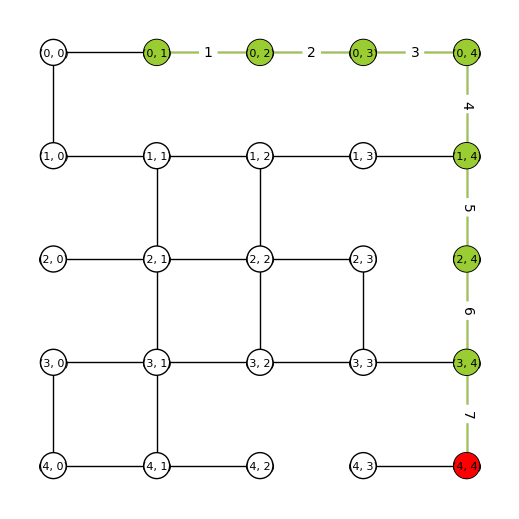

In [1517]:
road = setup_road(n_edges_to_remove=10)
knowledge_base = KnowledgeBase()
agent = Agent(road, knowledge_base)

path = agent.drive((0, 1), (4, 4))

**Висновок**: виконавши дану лабораторну роботу, було удосконалено інтелектуального агента розробленого у лабораторній роботі #2, шляхом створення та використання власної бази знань. Завдяки цим змінам та новій інформації про середовище, агент отримав можливість зберігати дану інформацію до бази знань, що дозволило йому краще орієнтуватися в просторі та уникати помилок.